In [12]:
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import re
import os


def load_and_clean_data(filepath):
    # Usa Path para garantir compatibilidade multiplataforma
    filepath = Path(filepath)

    # Verifica se o arquivo existe
    if not filepath.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {filepath}")

    # Carrega o dataset
    df = pd.read_csv(filepath)
    print('Dataset loaded successfully.')
    print('First 10 rows:\n', df.head(10).to_string())

    # Inspeção inicial
    print('Initial Check:')
    print(df.head().to_string())
    print(df.tail().to_string())
    df.info()
    print(df.dtypes)

    # Converte preço de centavos para reais
    if 'Preco_Normal' in df.columns:
        df['Preco_R$'] = df['Preco_Normal'] / 100
    else:
        raise KeyError("Coluna 'Preco_Normal' não encontrada no CSV.")

    # Extrai quantidade de unidades da coluna título pois existe produtos packs descritos no título.
    # A verificação é apenas comparativa para verificar diferenças entre o preço original e o tratado como unidades.
    # Apesar da atividade não cobrar tratamentos essa foi uma prática mínima de veirifcação.
    # Contudo estamos cientes que num arquivo desconhecido devemos elaborar um set de limpeza que cubra todas as situações.
    
    if 'title' in df.columns:
        df['Unidades'] = df['title'].str.extract(r'Pack (\d+) un').astype(float)
    else:
        raise KeyError("Coluna 'title' não encontrada no CSV.")

    # Preenche valores ausentes com 1
    df['Unidades'] = df['Unidades'].fillna(1).astype(int)

    # Remove linhas com preço zero ou nulo
    df = df[(df['Preco_R$'] != 0) & (df['Preco_R$'].notna())]

    # Calcula preço unitário
    df['Preco_Unitario'] = df['Preco_R$'] / df['Unidades']

    # Análise de valores nulos
    print('Null Value Analysis:')
    print(df.isnull().sum())
    print((df.isnull().mean() * 100).round(2))

    # Checagem final
    print(df.head().to_string())
    print(df.tail().to_string())
    df.info()

    # Valores únicos e estatísticas
    print('Unique Values:\n', df.nunique())
    print('Descriptive Statistics:\n', df.describe())

    return df


In [5]:
# Uitlizando a Função acima
os.chdir(r"C:/Users/ferna/price-analysis-chile") # Granti encontrar o arquivo
df = load_and_clean_data(r"C:\Users\ferna\price-analysis-chile\data\raw\MODULO7_PROJETOFINAL_BASE_SUPERMERCADO.csv")


Dataset loaded successfully.
First 10 rows:
                                               title       Marca  Preco_Normal  Preco_Desconto  Preco_Anterior  Desconto Categoria
0              Pack 12 un, Leche extra proteína 1 L  Loncoleche         19788               0               0         0   lacteos
1   Pack 12 un, Leche chocolate receta original 1 L     Soprole         18228               0               0         0   lacteos
2    Pack 12 un, Leche semidescremada chocolate 1 L     Soprole         18228               0               0         0   lacteos
3     Pack 12 un, Leche semidescremada frutilla 1 L     Soprole         18228               0               0         0   lacteos
4       Pack 12 un, Leche sin lactosa chocolate 1 L  Loncoleche         17988               0               0         0   lacteos
5        Pack 12 un, Leche sin lactosa frutilla 1 L  Loncoleche         17988               0               0         0   lacteos
6  Pack 12 un, Leche saborizada light chocola

# Análise Estatística por Categoria

In [6]:
categorias_unicas = df['Categoria'].unique()
print('Categorias únicas:', categorias_unicas)

Categorias únicas: ['lacteos' 'belleza-y-cuidado-personal' 'congelados' 'frutas'
 'comidas-preparadas' 'verduras' 'instantaneos-y-sopas']


In [14]:
df.groupby('Categoria')['title'].count().reset_index().sort_values(by='title', ascending=False)

,Categoria,title
5,lacteos,352
2,congelados,164
0,belleza-y-cuidado-personal,146
6,verduras,59
4,instantaneos-y-sopas,37
1,comidas-preparadas,36
3,frutas,19


# Estatística Básica

In [15]:
print('Análise de Dados Únicos: \n', df.nunique())
df.columns = df.columns.str.strip()

Análise de Dados Únicos: 
 title             781
Marca             127
Preco_Normal      360
Preco_Desconto      1
Preco_Anterior      1
Desconto            1
Categoria           7
Preco_R$          360
Unidades            7
Preco_Unitario    349
dtype: int64


# Média Pro Categoria

In [16]:
df.groupby('Categoria').agg({'Preco_Unitario': 'mean','Preco_R$': 'mean'}).round(2)

,Preco_Unitario,Preco_R$
Categoria,,
belleza-y-cuidado-personal,28.84,29.20
comidas-preparadas,39.55,39.55
congelados,30.21,30.21
frutas,17.24,17.24
instantaneos-y-sopas,11.79,11.79
lacteos,15.13,30.29
verduras,14.57,14.57


# Mediana Por Categoria

In [18]:
df.groupby('Categoria').agg({'Preco_Unitario': 'median','Preco_R$': 'median'}).round(2)

,Preco_Unitario,Preco_R$
Categoria,,
belleza-y-cuidado-personal,20.99,21.79
comidas-preparadas,37.40,37.40
congelados,29.54,29.54
frutas,11.95,11.95
instantaneos-y-sopas,6.89,6.89
lacteos,9.89,17.20
verduras,12.50,12.50


# Desvio padrão por categoria

In [19]:
df.groupby('Categoria').agg({'Preco_Unitario': 'std','Preco_R$': 'std'}).round(2)

,Preco_Unitario,Preco_R$
Categoria,,
belleza-y-cuidado-personal,21.67,21.63
comidas-preparadas,13.22,13.22
congelados,19.04,19.04
frutas,16.39,16.39
instantaneos-y-sopas,12.76,12.76
lacteos,17.82,41.99
verduras,9.72,9.72


# Boxplot de preços da categoria "lacteos"

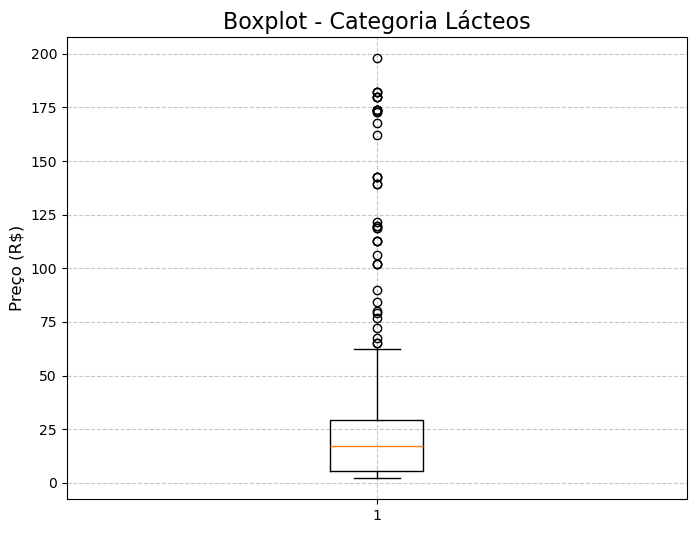

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(df[df['Categoria'] == 'lacteos']['Preco_R$'])
plt.title('Boxplot - Categoria Lácteos', fontsize=16)
plt.ylabel('Preço (R$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(r"C:\Users\ferna\price-analysis-chile\img\blox01.png", dpi=300)
plt.show()

# Boxplot comparativo (Preço Normal vs Unitário)

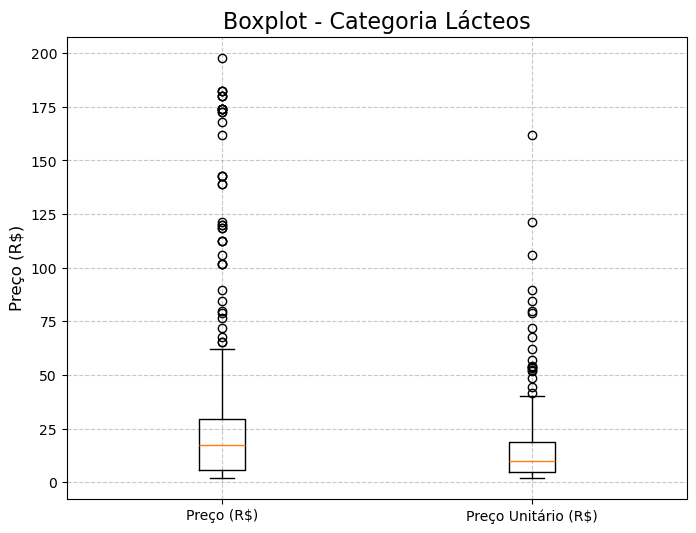

In [24]:
lacteos_df = df[df['Categoria'].str.lower().str.strip() == 'lacteos']

plt.figure(figsize=(8, 6))
plt.boxplot([
    lacteos_df['Preco_R$'].dropna(),
    lacteos_df['Preco_Unitario'].dropna()
])
plt.xticks([1, 2], ['Preço (R$)', 'Preço Unitário (R$)'])
plt.title('Boxplot - Categoria Lácteos', fontsize=16)
plt.ylabel('Preço (R$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(r"C:\Users\ferna\price-analysis-chile\img\blox02.png", dpi=300)
plt.show()

# Criar coluna de desconto*

* A coluna Desconto estava em branco no arquivo original. Então para fins didáticos adicionamos valores fictícios.

In [7]:
# Criar coluna com descontos aleatórios entre 5% e 15%
df['Desconto_%'] = np.random.uniform(5, 15, size=len(df)).round(2)

# Aplicar o desconto sobre o Preço Normal
df['Preco_Desconto'] = (df['Preco_R$'] * (1 - df['Desconto_%'] / 100)).round(2)

print('Análise de Dados Únicos: \n', df.nunique())
df.groupby('Categoria')['Preco_Desconto'].mean().round(2)


media = df['Desconto_%'].mean()

Análise de Dados Únicos: 
 title             781
Marca             127
Preco_Normal      360
Preco_Desconto    741
Preco_Anterior      1
Desconto            1
Categoria           7
Preco_R$          360
Unidades            7
Preco_Unitario    349
Desconto_%        571
dtype: int64


NameError: name 'plt' is not defined

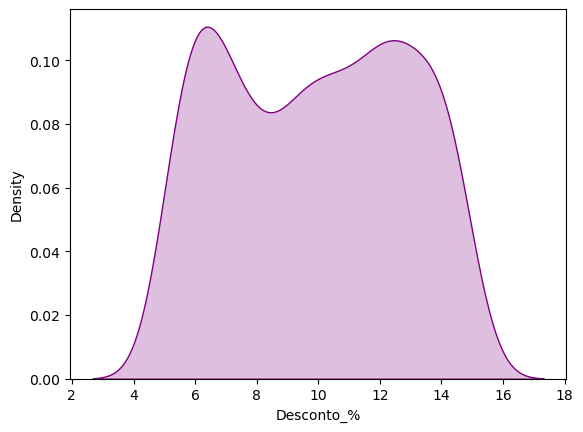

In [8]:
sns.kdeplot(df['Desconto_%'], fill=True, color='purple')
plt.title('Distribuição de Descontos (%)')
plt.xlabel('Desconto (%)')
plt.ylabel('Densidade')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(r"C:\Users\ferna\price-analysis-chile\img\dens01.png", dpi=300)
plt.show()

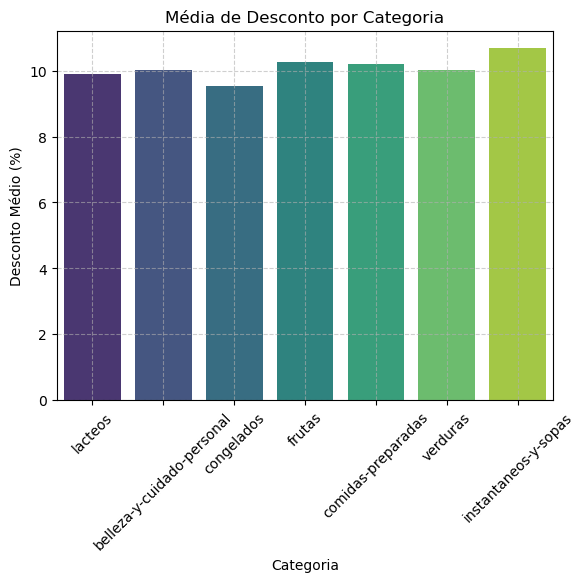

In [13]:
sns.barplot(data=df, x='Categoria', y='Desconto_%', estimator='mean', errorbar=None,
            hue='Categoria', legend=False, palette='viridis')
plt.title('Média de Desconto por Categoria')
plt.ylabel('Desconto Médio (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(r"C:\Users\ferna\price-analysis-chile\img\dens.png", dpi=300)
plt.show()

# Gráfico de barras por categoria

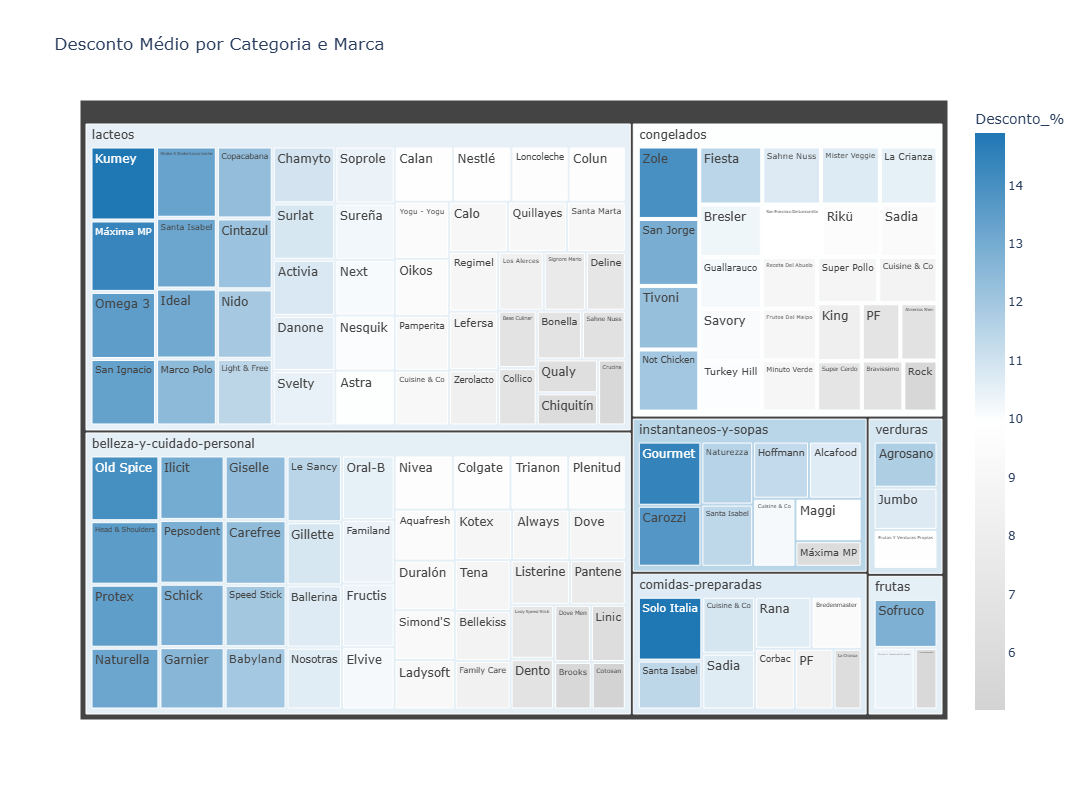

In [14]:
desconto_por_categoria_marca = df.groupby(['Categoria', 'Marca'])['Desconto_%'].mean().reset_index()

fig = px.treemap(
    desconto_por_categoria_marca,
    path=['Categoria', 'Marca'],
    values='Desconto_%',
    color='Desconto_%',
    title='Desconto Médio por Categoria e Marca',
    color_continuous_scale=['#d3d3d3', '#ffffff', '#1f77b4'],
    height=800
)

fig.write_html("docs/treemap_interativo.html")
fig.write_image(r"C:\Users\ferna\price-analysis-chile\img\treemap_interativo.png")
fig.show()